### TYK2 IL-23 RNA-seq

1. [Dataset Properties](#part1)
2. [Unsupervised Profiles](#part2)
3. [Statistical Modeling](#part3)
4. [Differentially Expressed Genes](#part4)
5. [Gene Visualizations](#part5)

In [2]:
library(ggpubr)
library(DESeq2)
library(ggcorrplot)
library(furrr)
library(ggbiplot)
library(patchwork)
library(ComplexHeatmap)
library(tidyverse)

#### Dataset Properties <a name="part1"></a>

In [3]:
alignments <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_star.txt") %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

count_summary <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_featureCounts.txt")  %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

Rows: 80 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (26): insertion_length, unmapped_other, multimapped_toomany_percent, unm...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 80 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (16): Unassigned_Chimera, Unassigned_Duplicate, Unassigned_NoFeatures, U...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


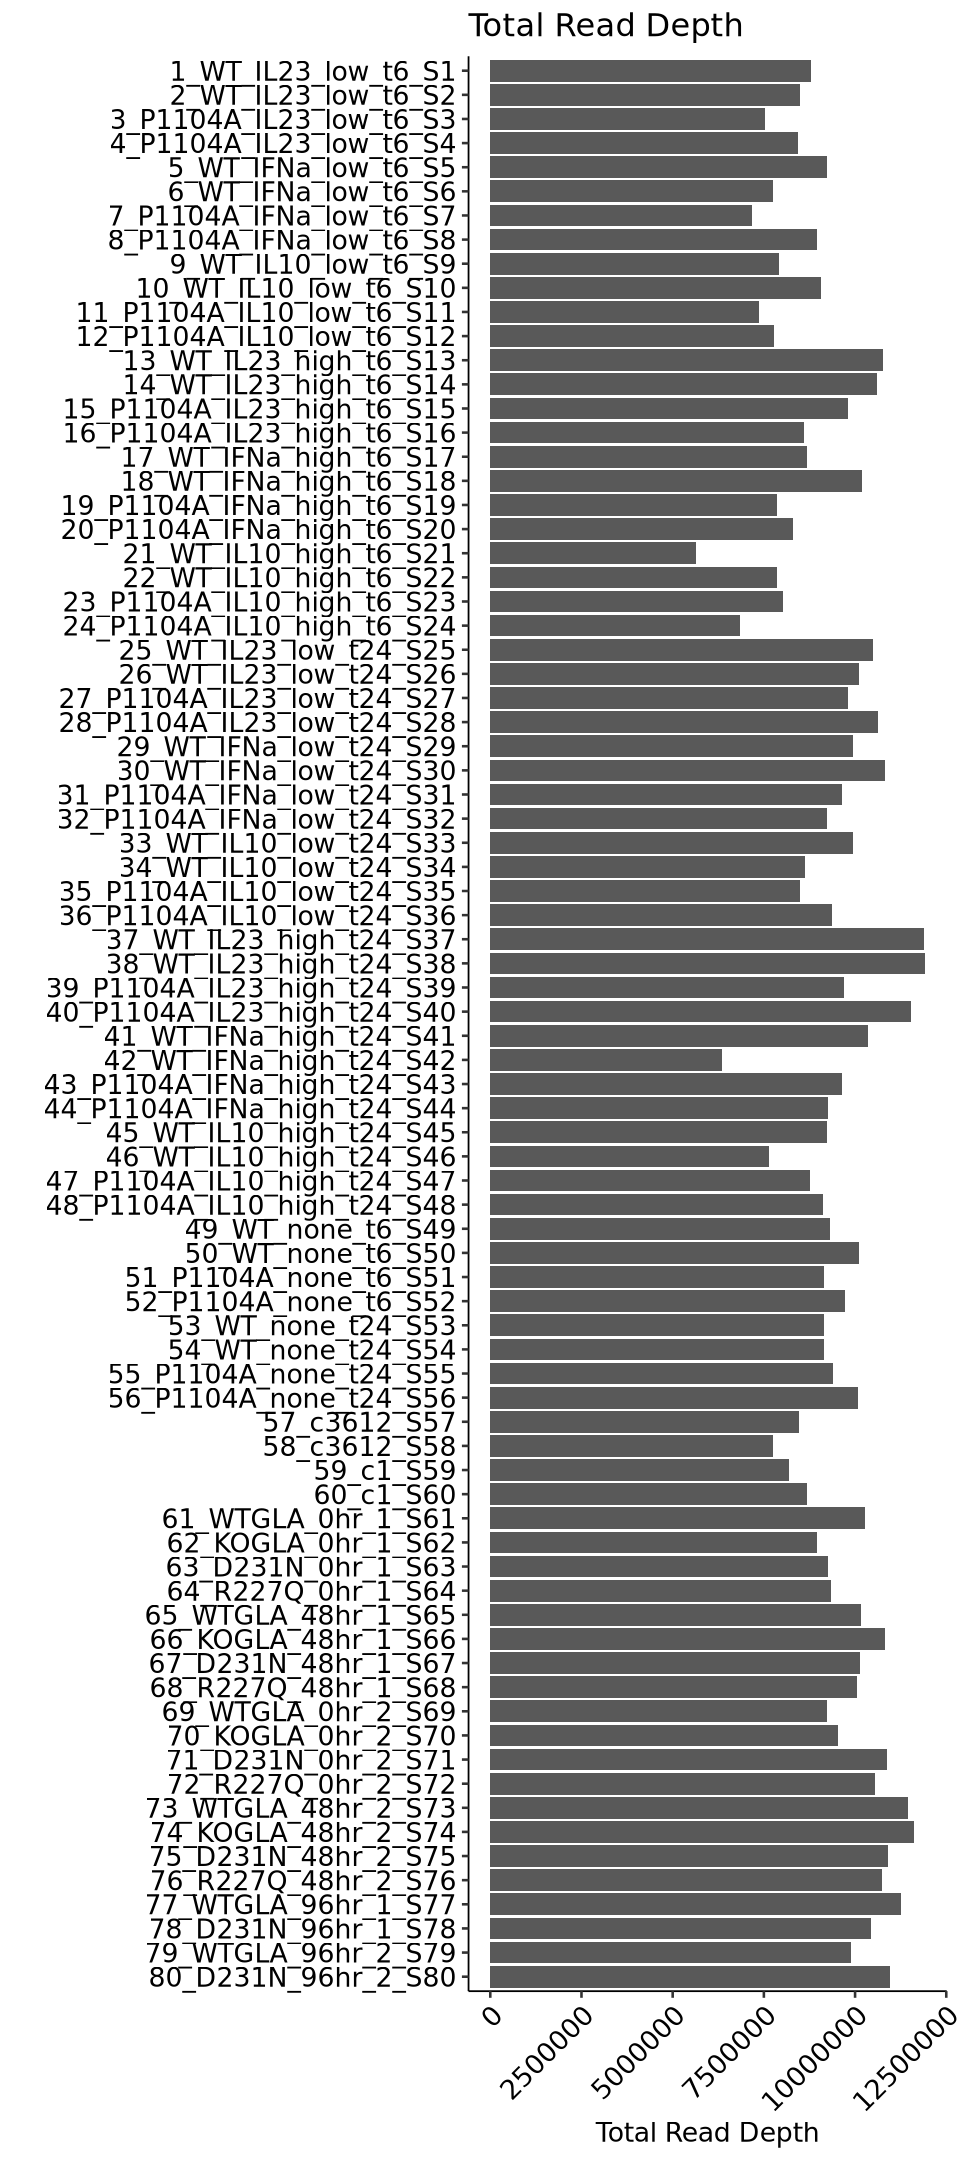

In [4]:
options(repr.plot.width = 8, repr.plot.height = 18)
alignments %>%
    ggplot() +
        geom_bar(aes(x = total_reads, y = reorder(Sample, -id)), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Total Read Depth") + ylab("") +
        ggtitle("Total Read Depth")

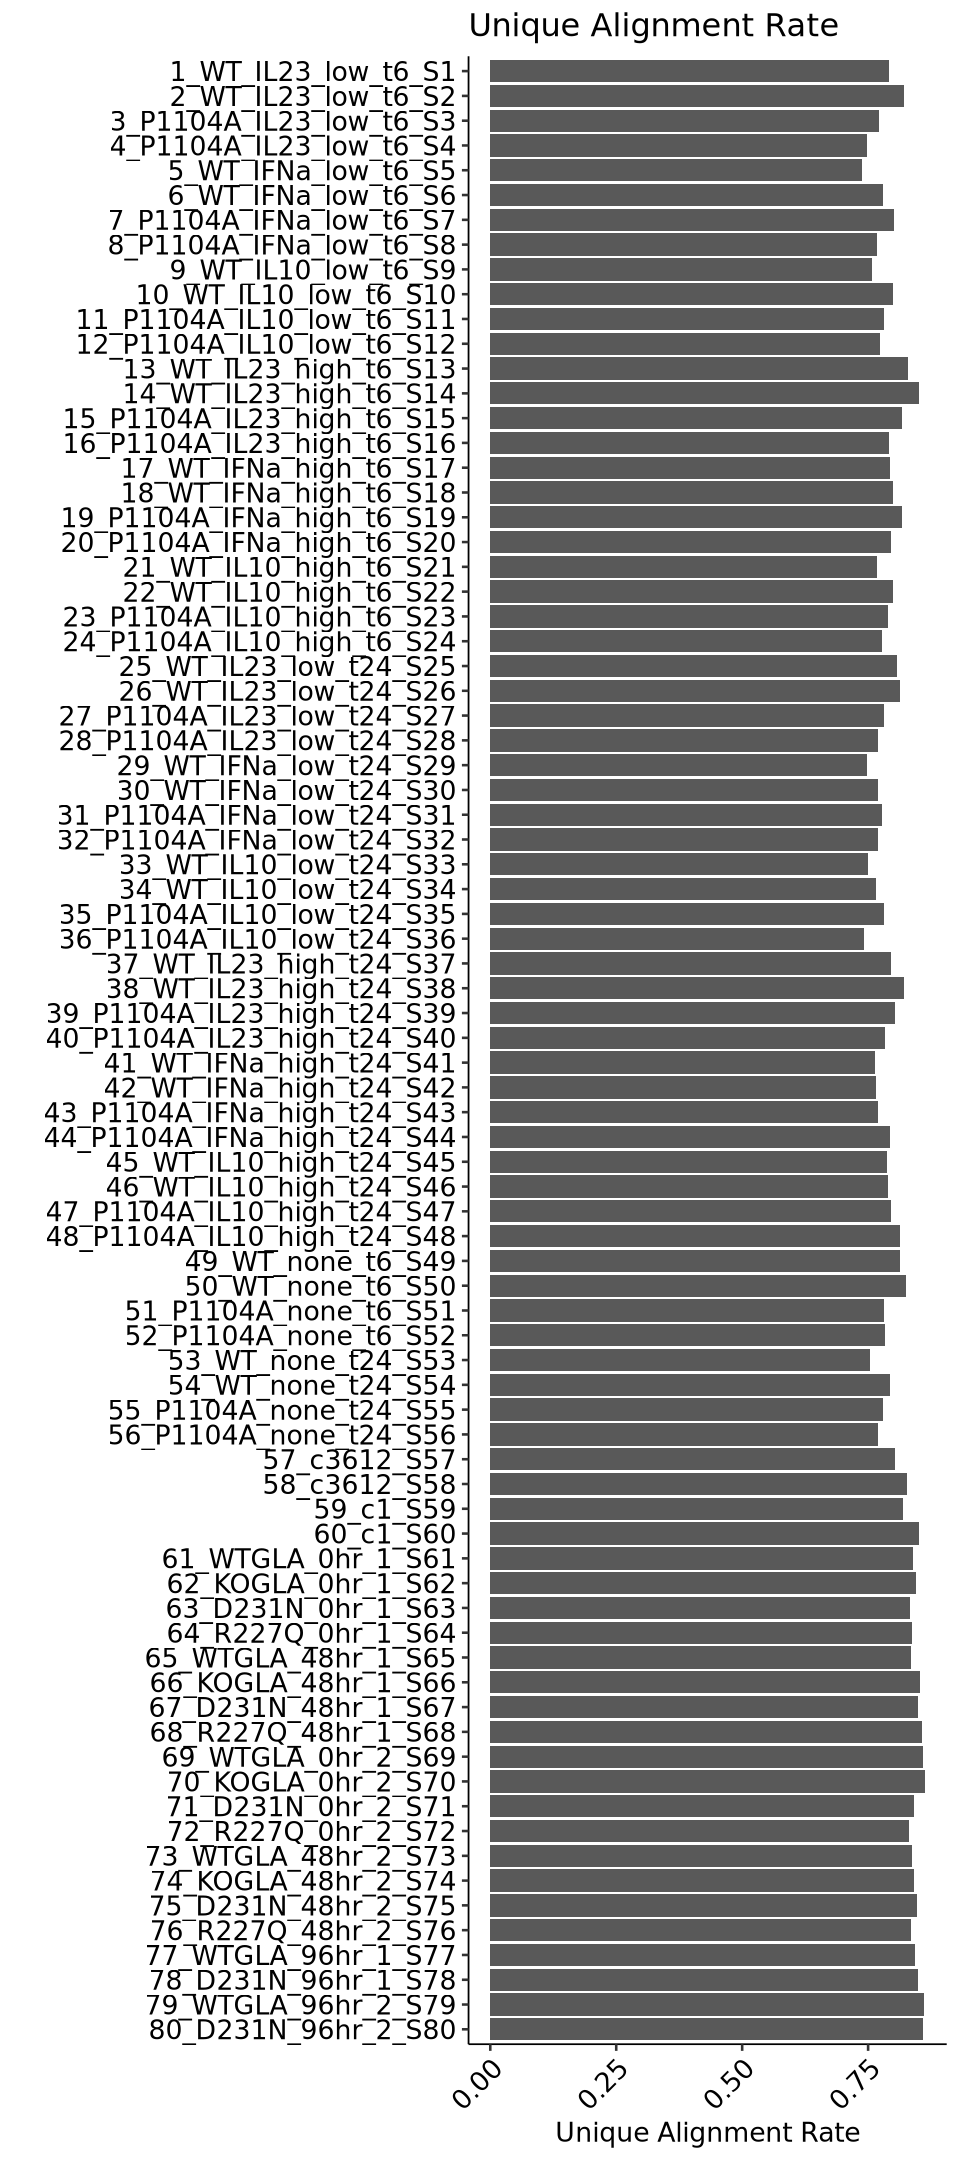

In [5]:
alignments %>%
    ggplot() +
        geom_bar(aes(x = uniquely_mapped_percent/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Unique Alignment Rate") + ylab("") +
        ggtitle("Unique Alignment Rate")

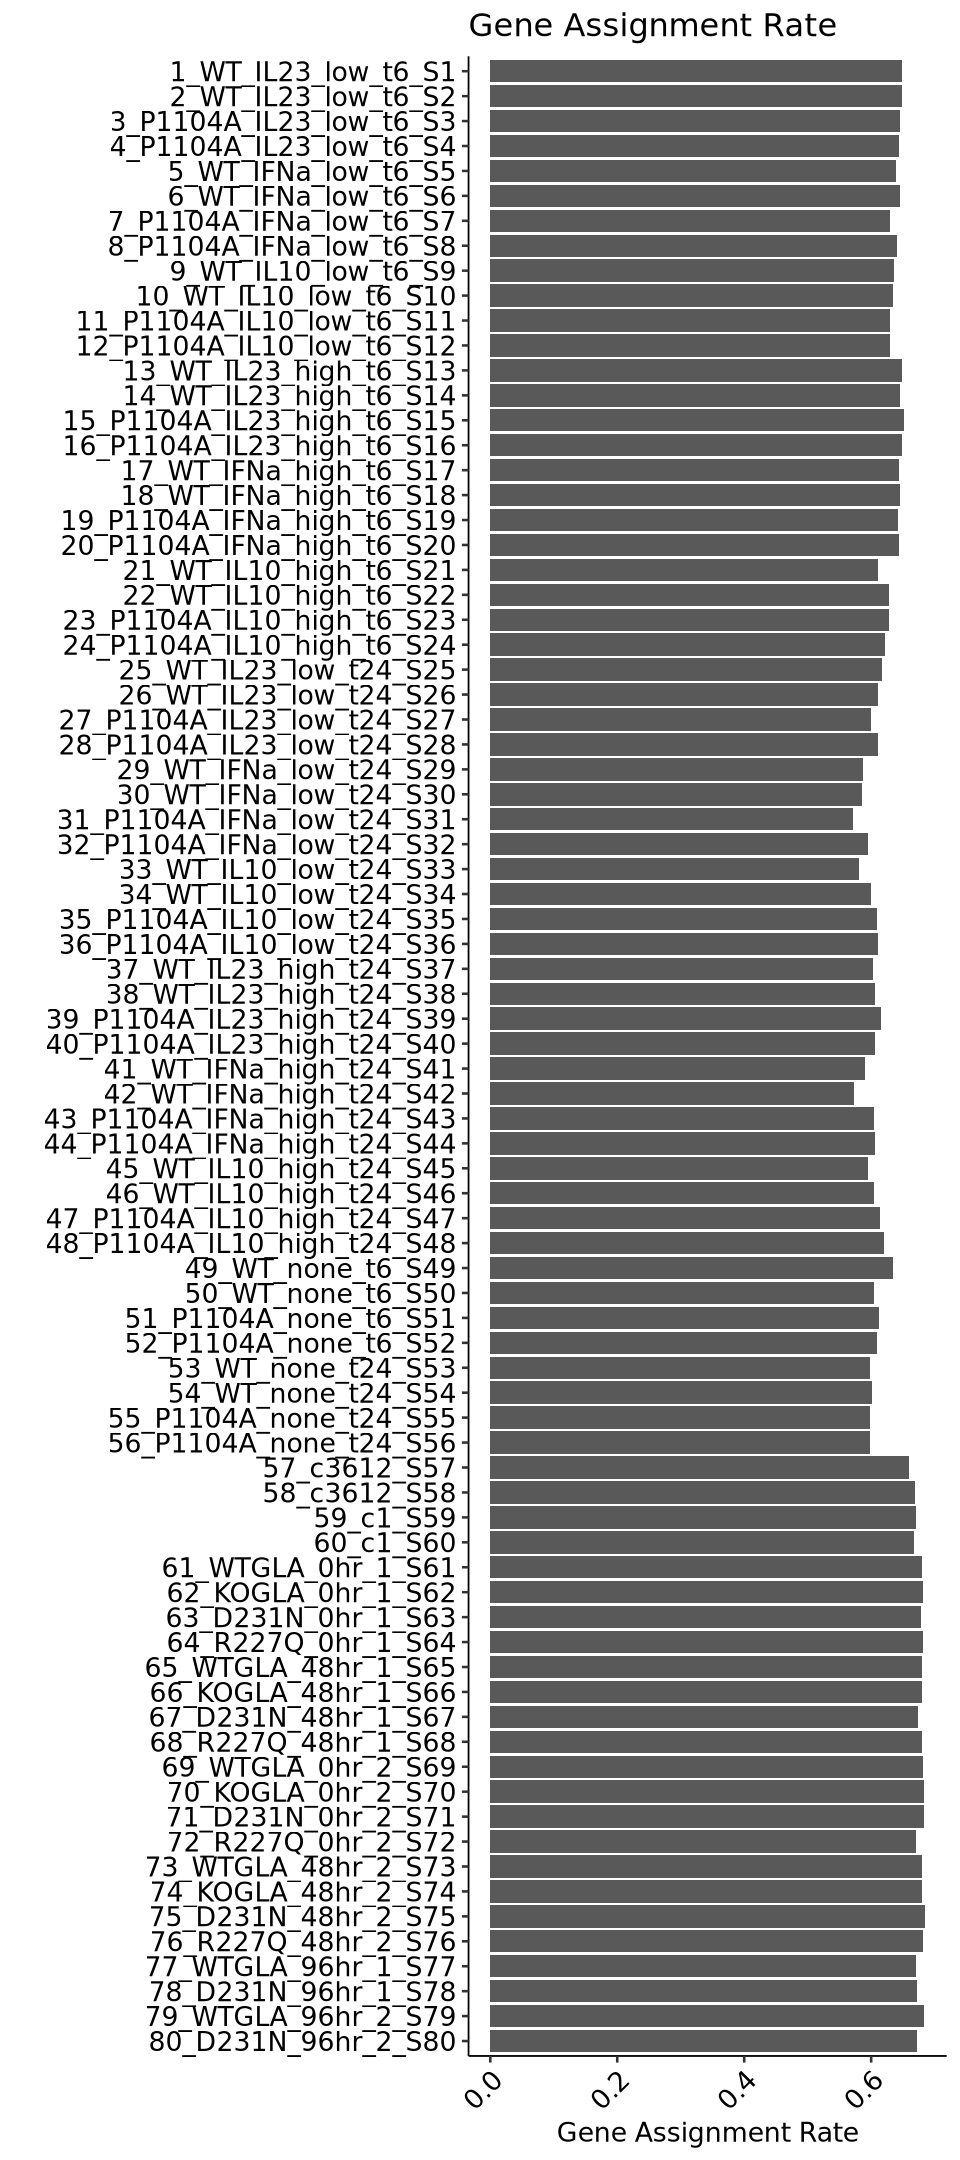

In [6]:
count_summary %>%
    ggplot() +
        geom_bar(aes(x = percent_assigned/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Gene Assignment Rate") + ylab("") +
        ggtitle("Gene Assignment Rate")

#### Unsupervised Profiles <a name="part2"></a>

In [4]:
paths <- str_c("../pipeline/diffexp/",
                    alignments$Sample,
                    ".counts.tsv")
names(paths) <- paths
df <- map_dfr(paths,
              ~read_tsv(.x,
                        col_names = NULL,
                        skip = 2,
                        col_select = c(1,7)),
              .id = "sample") %>%
    rename("gene" = "X1",
           "count" = "X7") %>%
    mutate(sample = gsub("../pipeline/diffexp/|.counts.tsv", "", sample))

samp_prop <- read_tsv("../sumstats/RNASEQ/run2/sample-properties-il23.tsv") %>%
    arrange(sample_id) %>%
    mutate(rep = rep(c(1,2), 40),
           covariate = as.factor(str_c(group, "_", cytokine, "_", dosage, "_", time)))
rownames(samp_prop) <- samp_prop$sample_id

df_id <- df %>%
    mutate(id = as.numeric(gsub("_.*", "", sample))) %>%
    select(-sample) %>%
    arrange(id)

Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


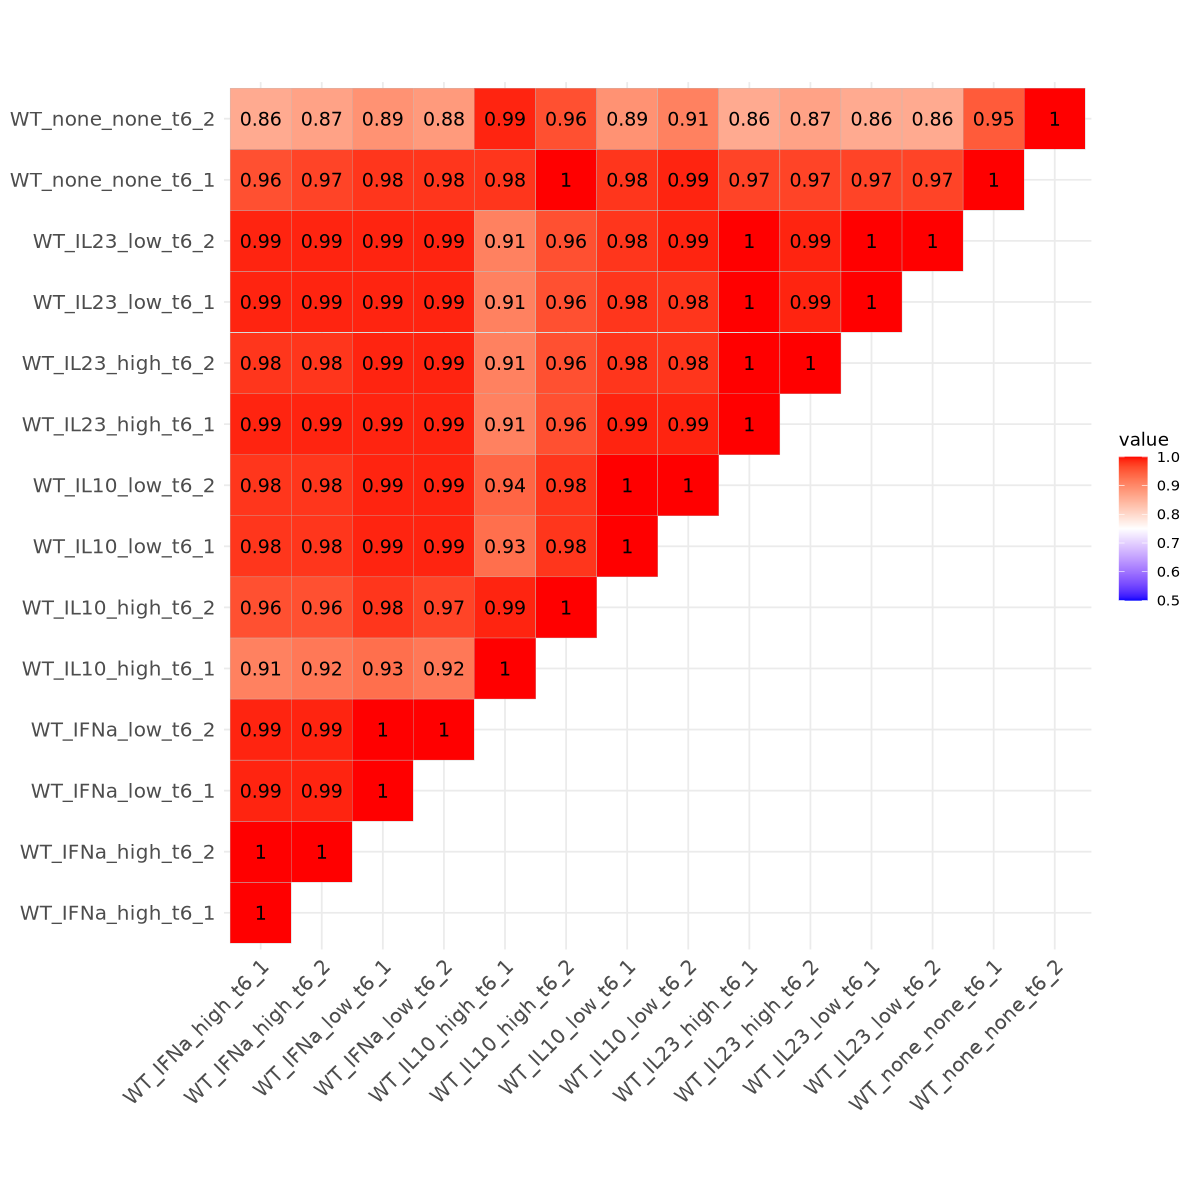

In [5]:
cor_data_wide <- inner_join(df_id, samp_prop, by = c("id" = "sample_id")) %>%
    filter(time == "t6", group == "WT",  count != 0) %>%
    arrange(cytokine, group, dosage, rep) %>%
    select(gene, covariate, rep, count) %>%
    mutate(count = log2(count)) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

cor_data_wide$v <- rowMeans(as.matrix(cor_data_wide[,-1]), na.rm = TRUE)

cor_data_filt <- cor_data_wide %>%
    arrange(-v) %>%
    head(1000) %>%
    select(-gene, -v)

cor_mat <- cor(cor_data_filt, use = "pairwise.complete.obs")

options(repr.plot.width = 10, repr.plot.height = 10)
ggcorrplot(cor_mat, lab = TRUE, lab_size = 4, hc.order = FALSE, type = "upper", show.diag = TRUE) +
    scale_fill_gradient2(limit = c(0.5,1), low = "blue", high =  "red", mid = "white", midpoint = 0.75)

In [7]:
pca_data <- inner_join(df_id, samp_prop, by = c("id" = "sample_id")) %>%
    filter(!is.na(covariate)) %>%
    arrange(cytokine, group, dosage, rep) %>%
    select(gene, covariate, rep, count) %>%
    mutate(count = log2(count + 1)) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

pca_data <- t(as.matrix(pca_data[,-1]))

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


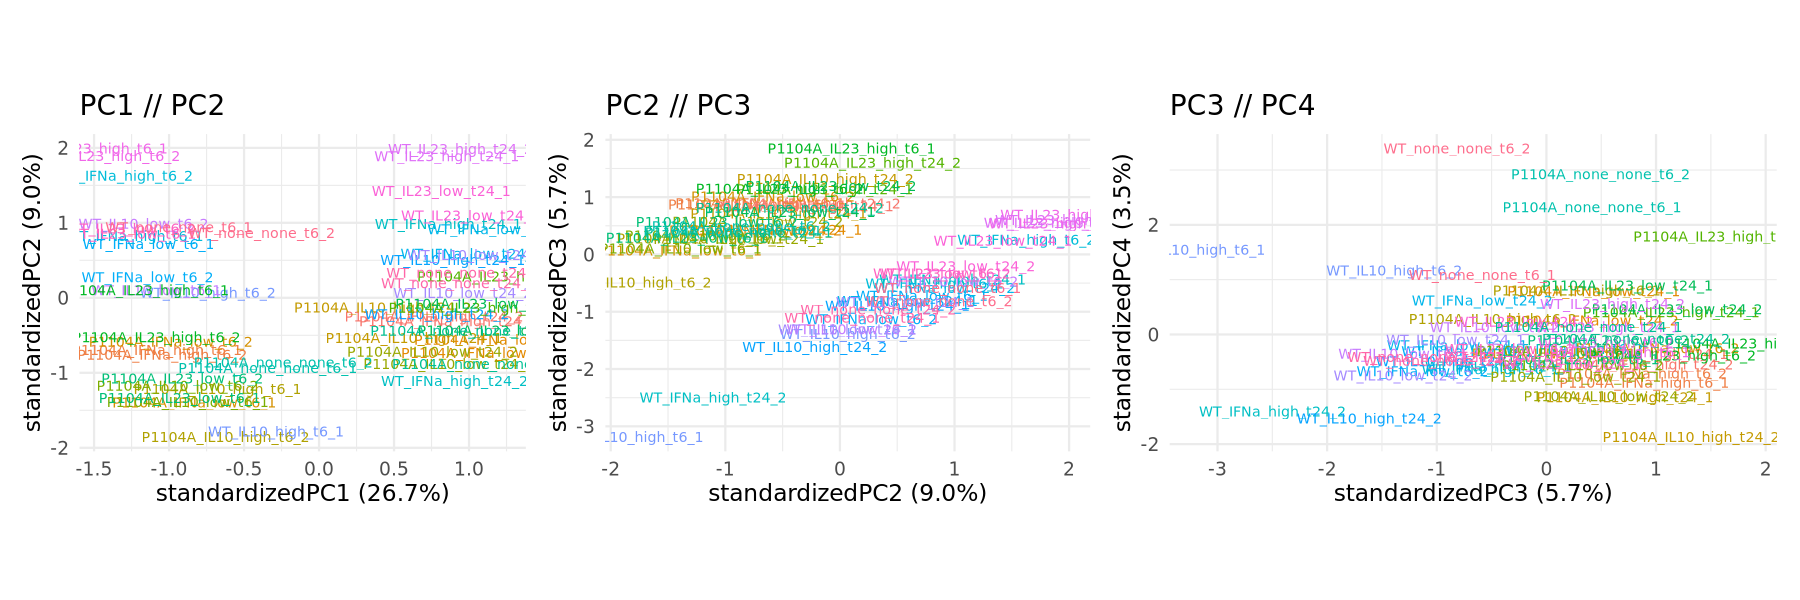

In [19]:
pca1 <- ggbiplot(prcomp(pca_data[,colVars(pca_data) > 0]),labels.size = 3,
         var.axes = FALSE,
         labels = rownames(pca_data),
         groups = gsub("_1|_2", "",  rownames(pca_data)),
         choices = 1:2,) +
        ggtitle("PC1 // PC2")

pca2 <- ggbiplot(prcomp(pca_data[,colVars(pca_data) > 0]),labels.size = 3,
         var.axes = FALSE,
         labels = rownames(pca_data),
         groups = gsub("_1|_2", "",  rownames(pca_data)),
         choices = 2:3,) +
        ggtitle("PC2 // PC3")

pca3 <- ggbiplot(prcomp(pca_data[,colVars(pca_data) > 0]),labels.size = 3,
         var.axes = FALSE,
         labels = rownames(pca_data),
         groups = gsub("_1|_2", "",  rownames(pca_data)),
         choices = 3:4,) +
        ggtitle("PC3 // PC4")

options(repr.plot.width = 15, repr.plot.height = 5, warn = -1)
pca1 + pca2 + pca3  &
  theme_minimal(base_size = 14) &
  theme(legend.position = "none") &
  coord_equal(ratio = 0.5)

#### Statistical Modeling <a name="part3"></a>

In [6]:
de_data <- df_id %>%
    filter(id %in% 1:56) %>%
    pivot_wider(names_from = id, values_from = count)

de_prop <- samp_prop %>% filter(sample_id %in% 1:56)

# de_prop[21,1] <- 49
# de_prop[49,1] <- 21
# de_prop <- de_prop %>% arrange(sample_id)

rownames(de_prop) <- de_prop$sample_id

Warning message:
“Setting row names on a tibble is deprecated.”


In [7]:
raw_counts <- de_data
names(raw_counts)[-1] <- str_c(de_prop$covariate, "_", de_prop$rep)
write_tsv(raw_counts, "../sumstats/RNASEQ/run2/raw-counts.tsv")

In [ ]:
log2_cpm <- raw_counts %>%
    pivot_longer(names_to = "sample", values_to = "count", -gene) %>%
    group_by(sample) %>%
    mutate(count = log2(count * 1000000 / sum(count, na.rm = TRUE)),
           count = if_else(is.infinite(count), NA, count)) %>%
    pivot_wider(names_from = sample, values_from = count)

write_tsv(log2_cpm, "../sumstats/RNASEQ/run2/log2-cpm.tsv")

In [15]:
deobj_counts <- DESeqDataSetFromMatrix(countData = de_data %>% select(-gene),
    colData = de_prop,
    design = ~covariate)

deresult <- DESeq(deobj_counts)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [65]:
cov_group <- de_prop %>%
    filter(!grepl("none", covariate)) %>%
    distinct(covariate) %>%
    pull(covariate) %>%
    as.character()

none_group <- gsub("IFNa|IL10|IL23|low|high", "none", cov_group) %>%
    as.character()

plan(multicore, workers = 25)
norm_result <- future_map2(.x = cov_group,
                    .y = none_group,
                    ~results(deresult,
                             contrast = c("covariate", .x, .y),
                             independentFiltering = FALSE))

sumstats <- map2_dfr(norm_result,
                     cov_group,
                     ~bind_cols("gene" = de_data$gene,
                                            as_tibble(.x),
                                            "condition" = .y))

sumstats %>%
    separate(condition, c("background", "cytokine", "dosage", "time"), "_") %>%
    write_tsv("../sumstats/RNASEQ/run2/deseq2-sumstats-vs-none.tsv")

In [66]:
sumstats <- read_tsv( "../sumstats/RNASEQ/run2/deseq2-sumstats-vs-none.tsv")
split_sumstats <- sumstats %>%
    mutate(group = case_when(padj == 1 ~ "FDR = 1",
                             padj < 0.01 ~ "FDR < 0.01",
                             TRUE ~ "NS")) %>%
    mutate(time = relevel(as.factor(time), ref = "t6"),
           dosage = relevel(as.factor(dosage), ref = "low"))

ma_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2(baseMean),
                       y = log2FoldChange,
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red"))

Rows: 1454568 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, background, cytokine, dosage, time
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


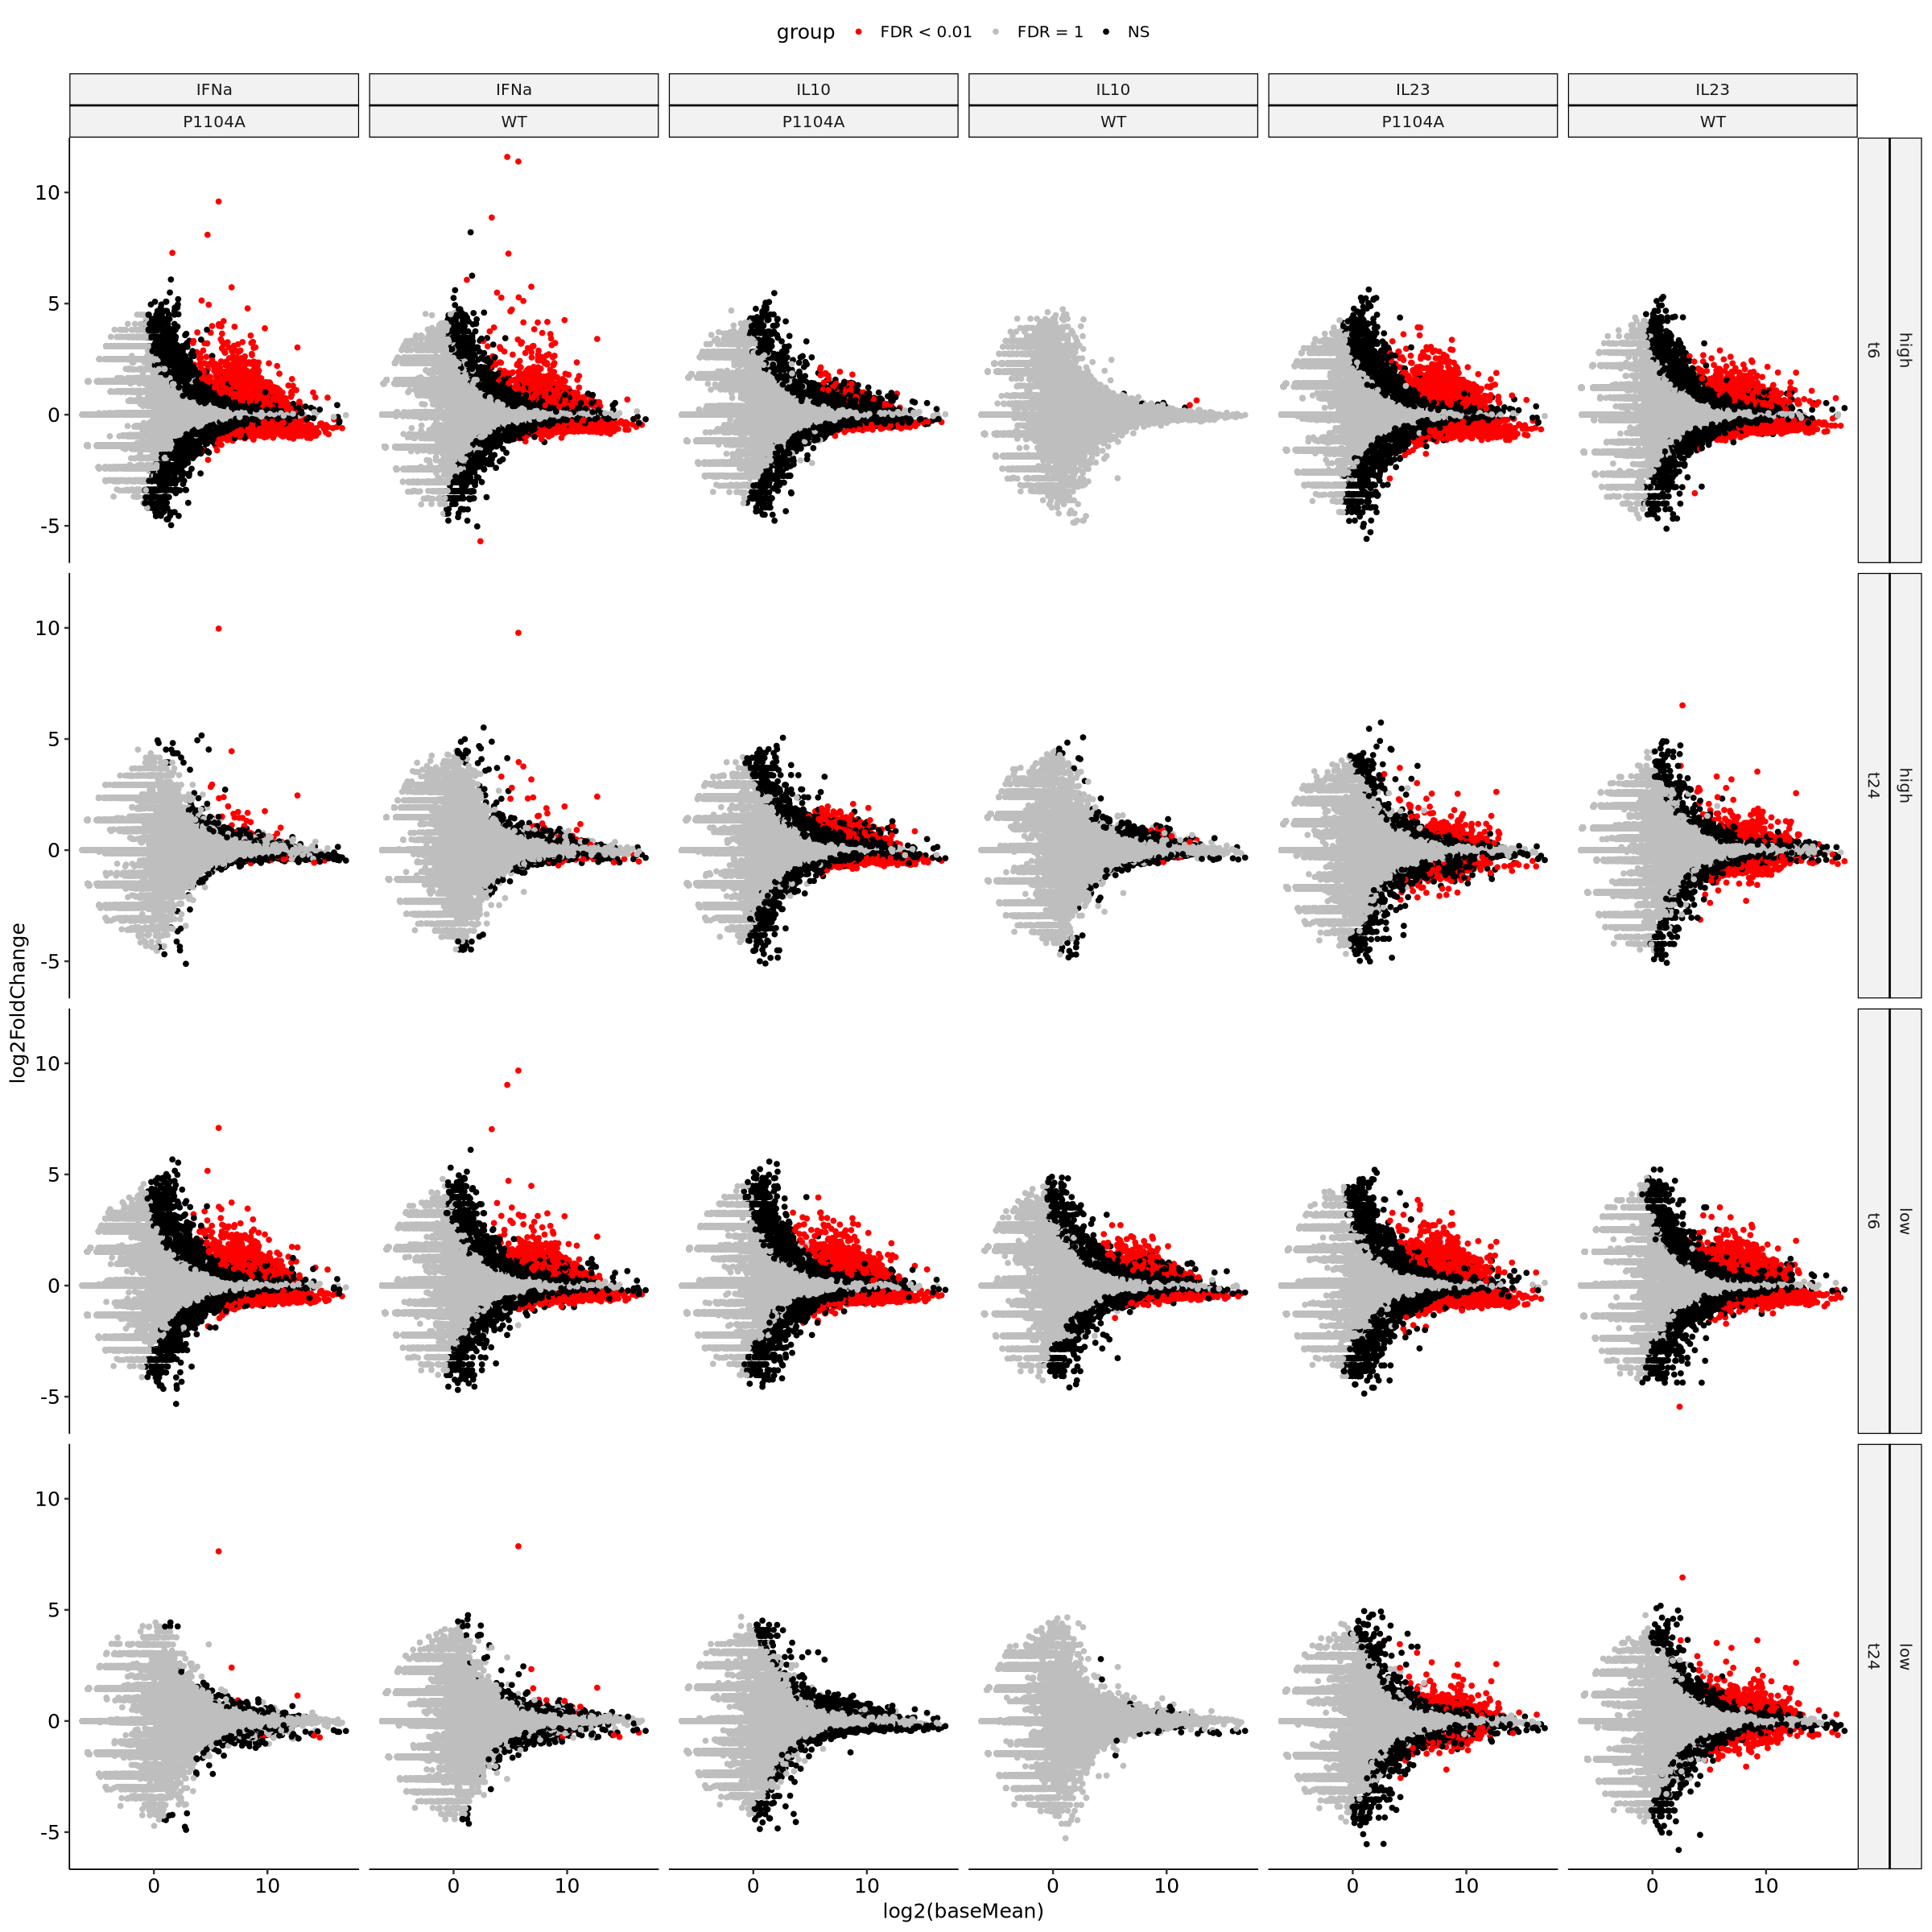

In [18]:
options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
ma_grid

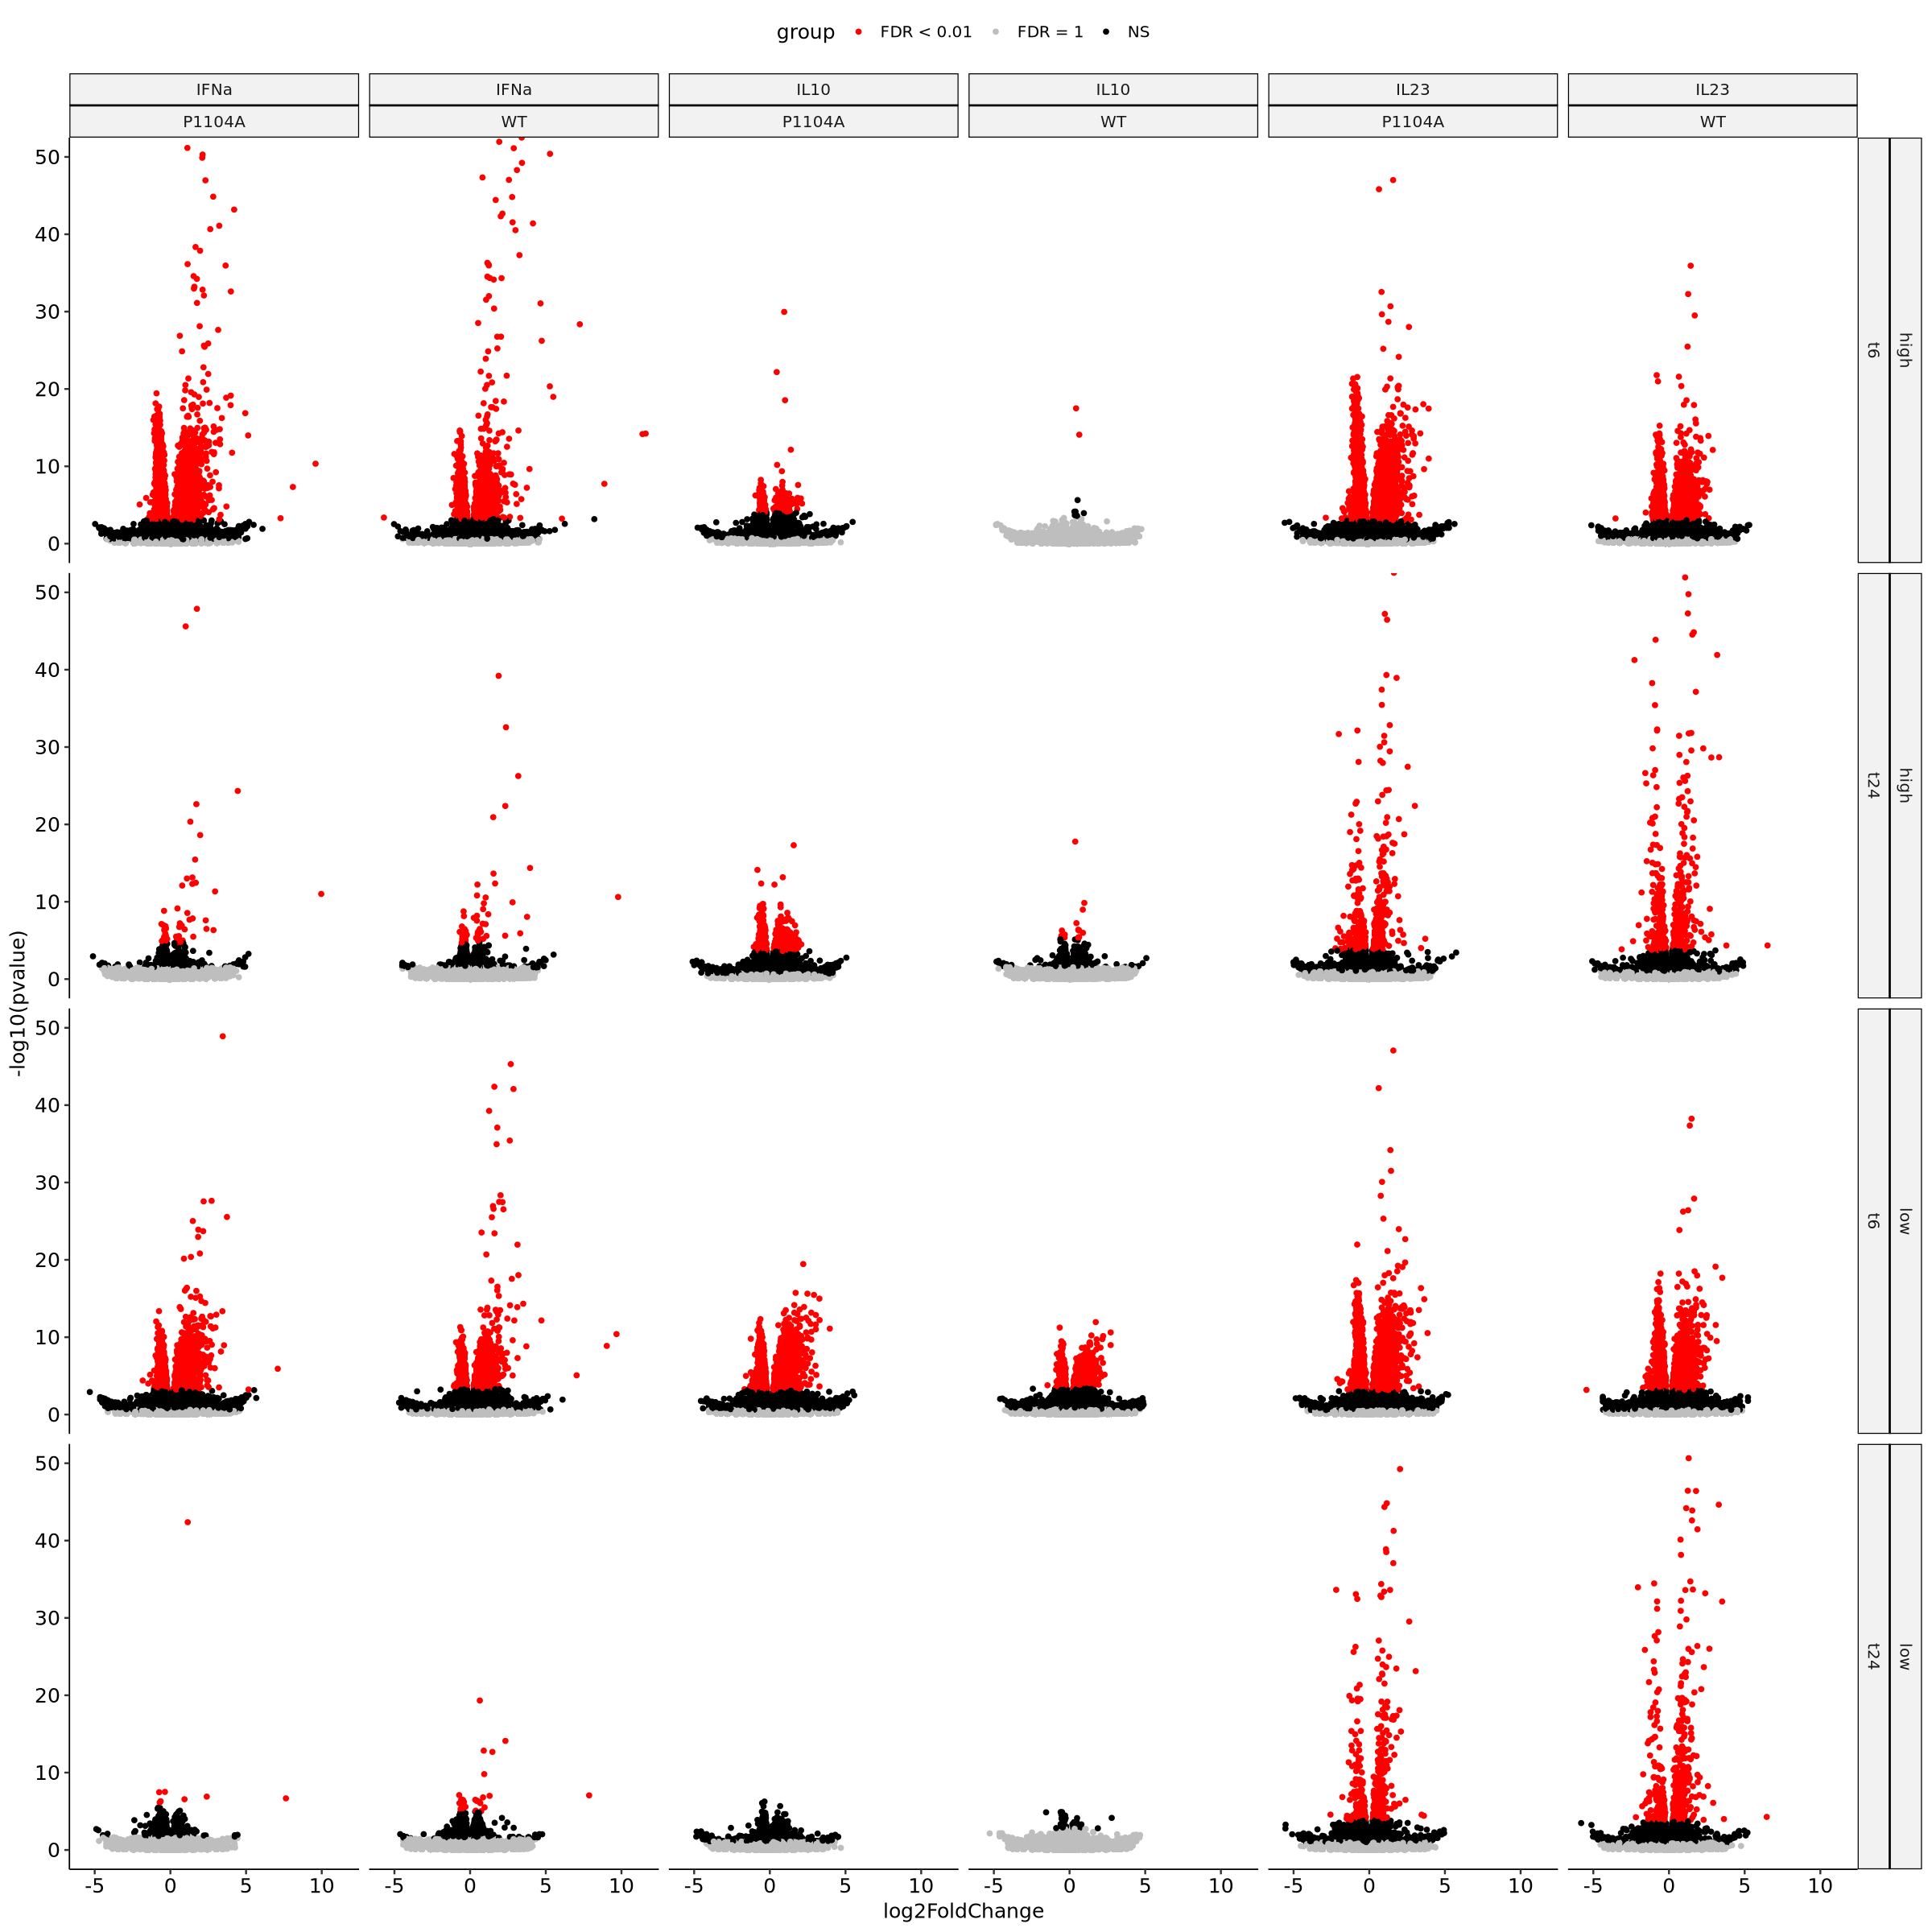

In [21]:
volcano_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange,
                       y = -log10(pvalue),
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red")) +
        coord_cartesian(ylim = c(0, 50))

options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
volcano_grid

background,cytokine,dosage,time,FDR < 0.01 vs Untreated
<chr>,<chr>,<fct>,<fct>,<int>
WT,IFNa,low,t6,1532
WT,IFNa,high,t6,2058
P1104A,IFNa,low,t6,2095
P1104A,IFNa,high,t6,2900
WT,IL10,low,t6,1098
WT,IL10,high,t6,2
P1104A,IL10,low,t6,2082
P1104A,IL10,high,t6,302
WT,IL23,low,t6,2212


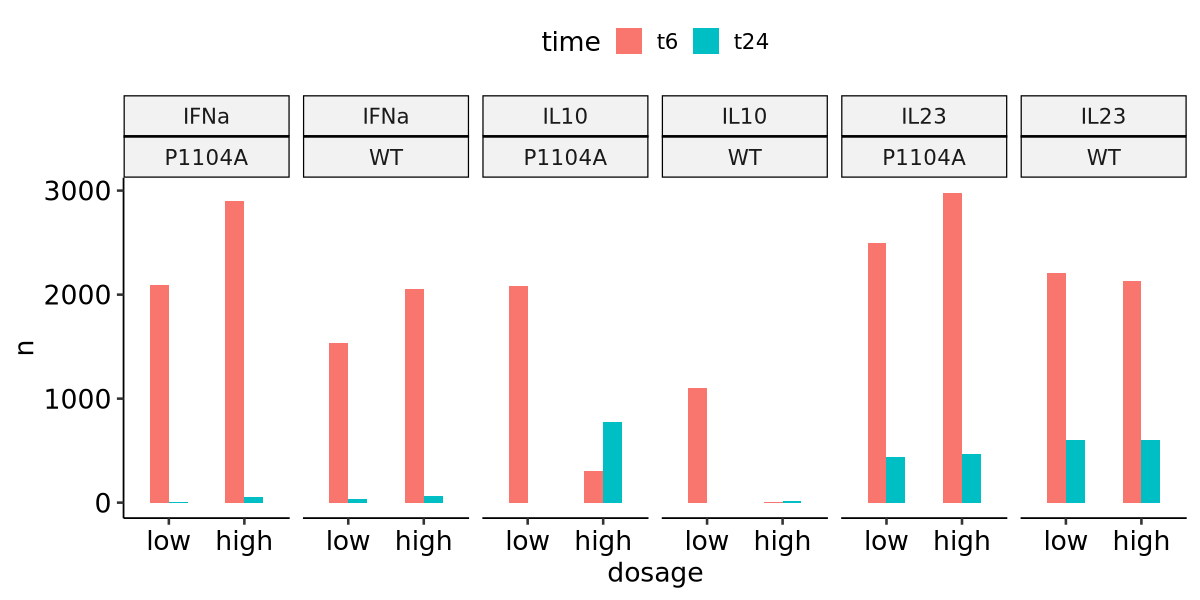

In [94]:
options(repr.plot.width = 10, repr.plot.height = 5)
split_sumstats  %>%
    filter(group == "FDR < 0.01") %>%
    group_by(background, cytokine, dosage, time) %>%
    count(group, .drop = FALSE) %>%
    ggplot() +
        geom_bar(aes(x = dosage,
                     y = n,
                     fill = time),
                 position = position_dodge(0.5),
                 width = 0.5,
                 stat = "identity")  +
        facet_grid(cols = vars(cytokine, background)) +
        theme_pubr(base_size = 16)

split_sumstats  %>%
    filter(group == "FDR < 0.01") %>%
    group_by(background, cytokine, dosage, time) %>%
    count(group, .drop = FALSE) %>%
    select(-group) %>%
    arrange(time, cytokine, rev(background), dosage) %>%
    rename("FDR < 0.01 vs Untreated" = "n")

#### Differentially Expressed Genes <a name="part4"></a>

In [68]:
vsd <- assay(vst(deresult, blind = FALSE))
vsd <- cbind(vsd, "row_var" = rowVars(vsd, na.rm = TRUE))

vsd_gene <- bind_cols("gene" = de_data$gene,
                      vsd) %>%
    pivot_longer(names_to = "sample", values_to = "norm_value", `1`:`56`) %>%
    inner_join(de_prop %>% mutate(sample_id = as.character(sample_id)),
               by = c("sample" = "sample_id")) %>%
    arrange(cytokine, group, dosage, time, rep)

var_genes <- vsd_gene %>%
    select(gene, row_var) %>%
    distinct() %>%
    arrange(-row_var) %>%
    head(500) %>%
    pull(gene)

vsd_gene_wide_sig <- vsd_gene %>%
    filter(gene %in% var_genes) %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_gene_wide_all <- vsd_gene %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

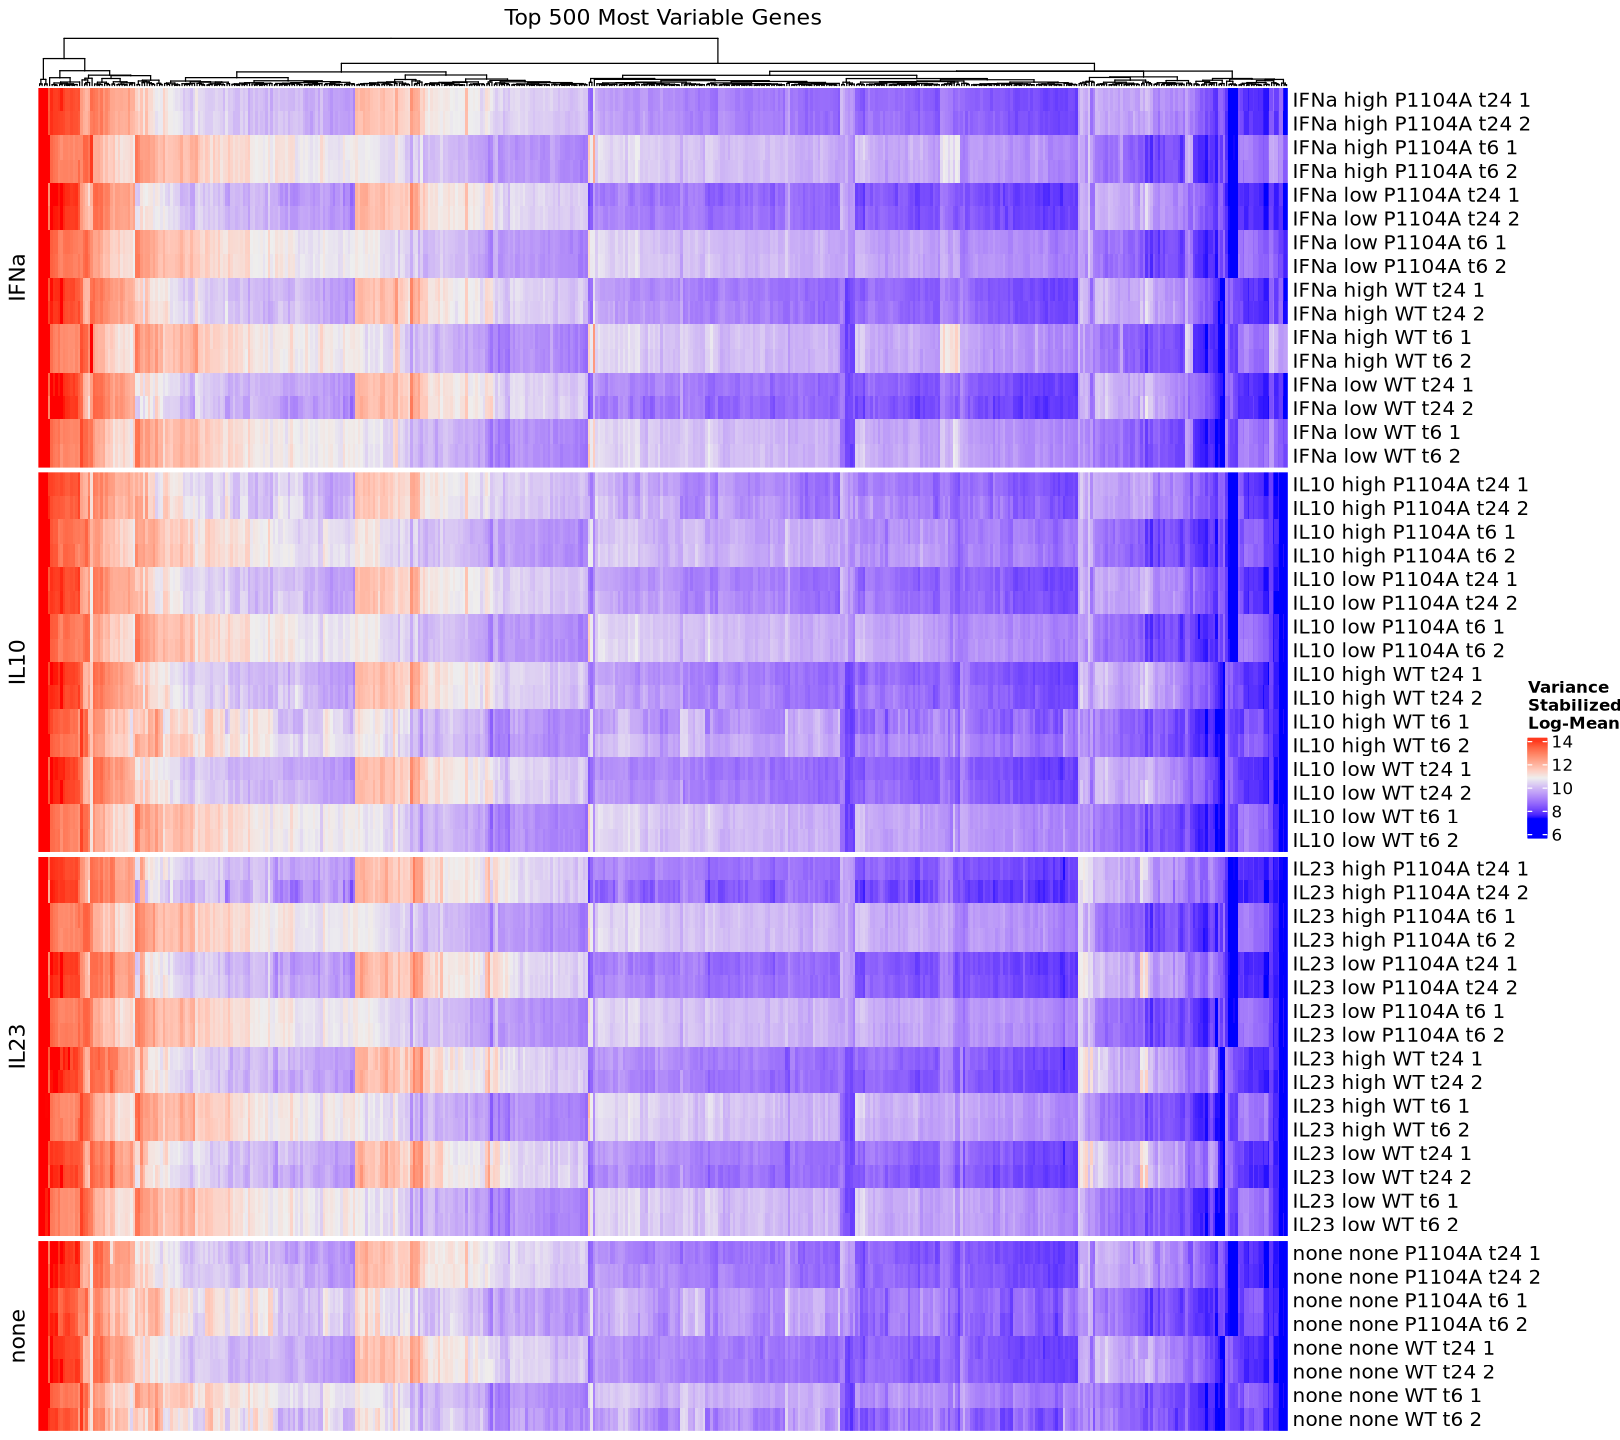

In [69]:
options(repr.plot.width = 13.5, repr.plot.height = 12)
Heatmap(t(as.matrix(vsd_gene_wide_sig[,-1])),
        column_title = "Top 500 Most Variable Genes",
        cluster_columns = TRUE,
        cluster_rows = FALSE,
        row_split = gsub(" .*", "", names(vsd_gene_wide_sig[,-1])),
        use_raster = TRUE,
        raster_by_magick = TRUE,
        name = "Variance\nStabilized\nLog-Mean")

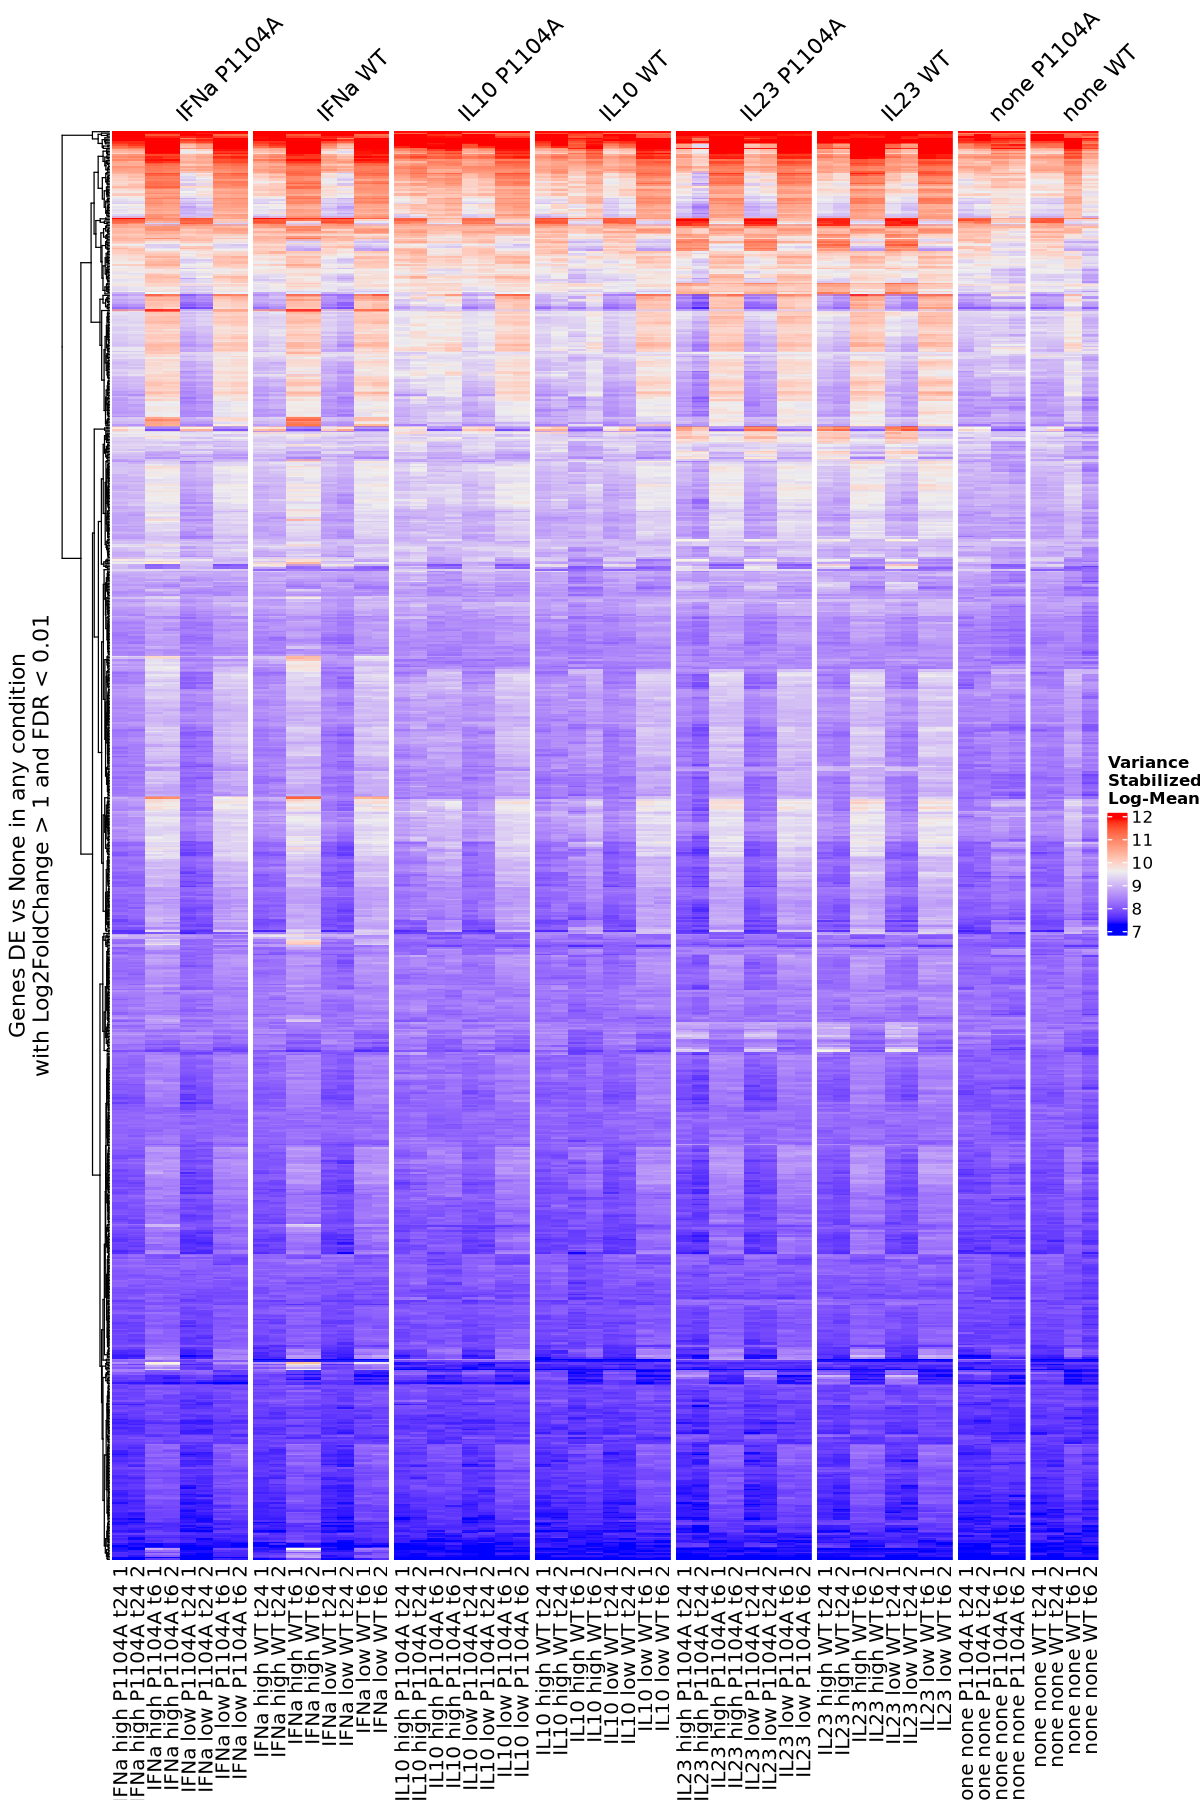

In [70]:
de_genes_sig <- split_sumstats %>%
    filter(log2FoldChange > 1, padj < 0.01, !grepl("ENSG", gene)) %>%
    pull(gene) %>%
    unique()

heat_genes_wide <- vsd_gene_wide_all[vsd_gene_wide_all$gene %in% de_genes_sig,]
heat_data <- t(as.matrix(heat_genes_wide[,-1]))
colnames(heat_data) <- unlist(heat_genes_wide[,1])

options(repr.plot.width = 10, repr.plot.height = 15)
Heatmap(t(heat_data),show_row_names = FALSE,
        cluster_columns = FALSE,
        cluster_rows = TRUE,
        column_split = gsub("low |high |t6|t24| 1| 2| none", "", colnames(heat_genes_wide[,-1])),
        use_raster = TRUE,
        column_title_rot = 45,
        name = "Variance\nStabilized\nLog-Mean",
        row_title = "Genes DE vs None in any condition\nwith Log2FoldChange > 1 and FDR < 0.01")

#### Gene Visualizations <a name="part5"></a>

In [77]:
plot_gene <- function(gene_id) {

    the_plot <- split_sumstats %>%
        filter(gene == gene_id) %>%
        mutate(dosage = relevel(as.factor(dosage), ref = "low")) %>%
        ggplot() +
            geom_pointrange(aes(x = dosage,
                                y = log2FoldChange,
                                ymin = log2FoldChange - 2*lfcSE,
                                ymax = log2FoldChange + 2*lfcSE,
                                color = time), position = position_dodge(width = 0.4)) +
            theme_pubr(base_size = 16,
                       x.text.angle = 45) +
            ggtitle(gene_id) +
            geom_hline(yintercept = 0) +
            facet_grid(cols = vars(cytokine, background))

    return(the_plot)
    
}


stat1 <- plot_gene("STAT1")
stat2 <- plot_gene("STAT2")
stat3 <- plot_gene("STAT3")

jak1 <- plot_gene("JAK1")
jak2 <- plot_gene("JAK2")
jak3 <- plot_gene("JAK3")

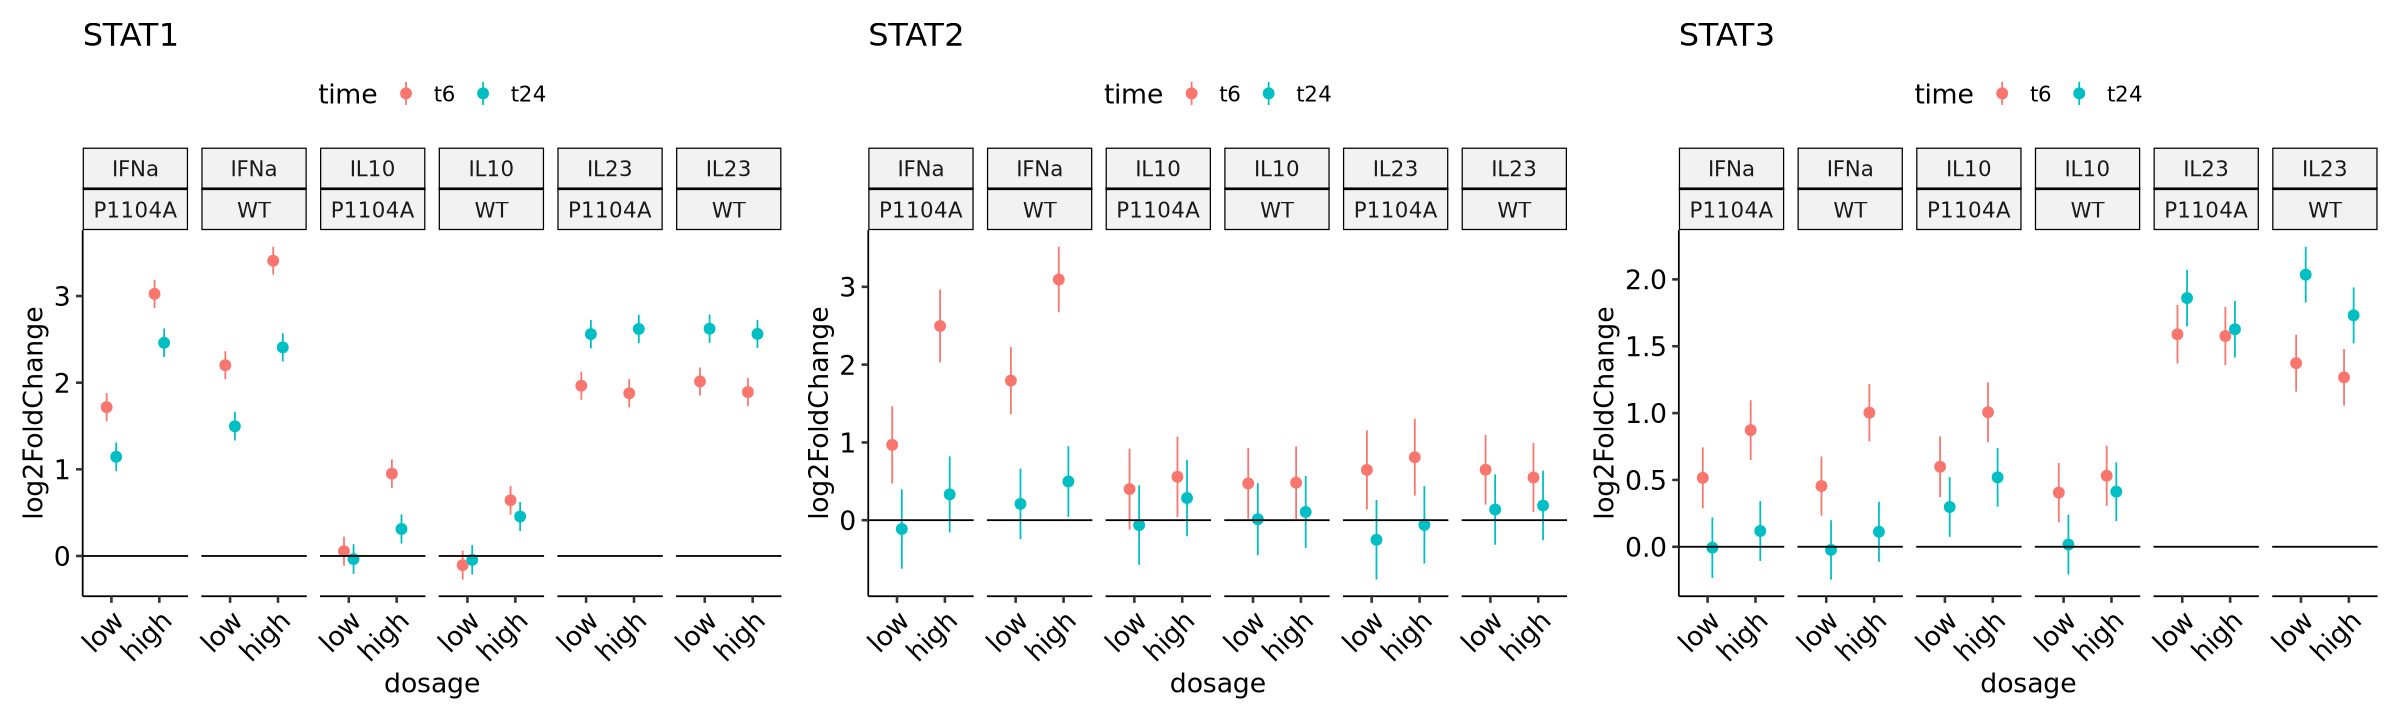

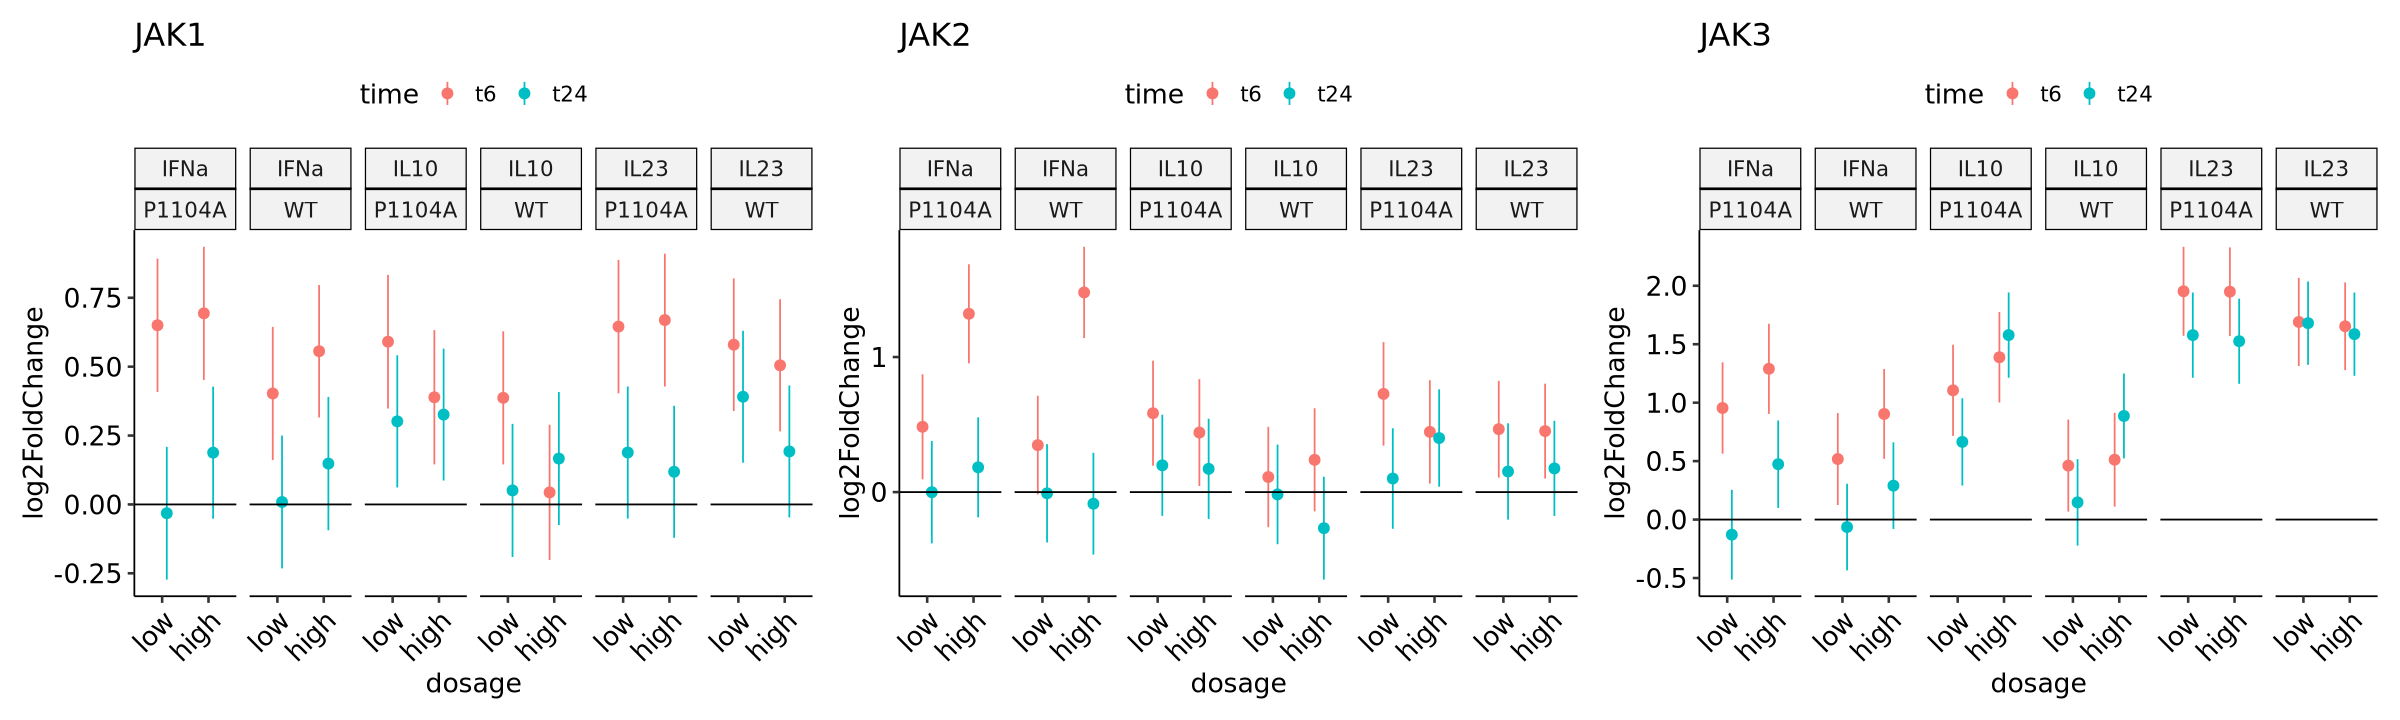

In [72]:
options(repr.plot.width = 20, repr.plot.height = 6)
stat1 + stat2 + stat3
jak1 + jak2 + jak3

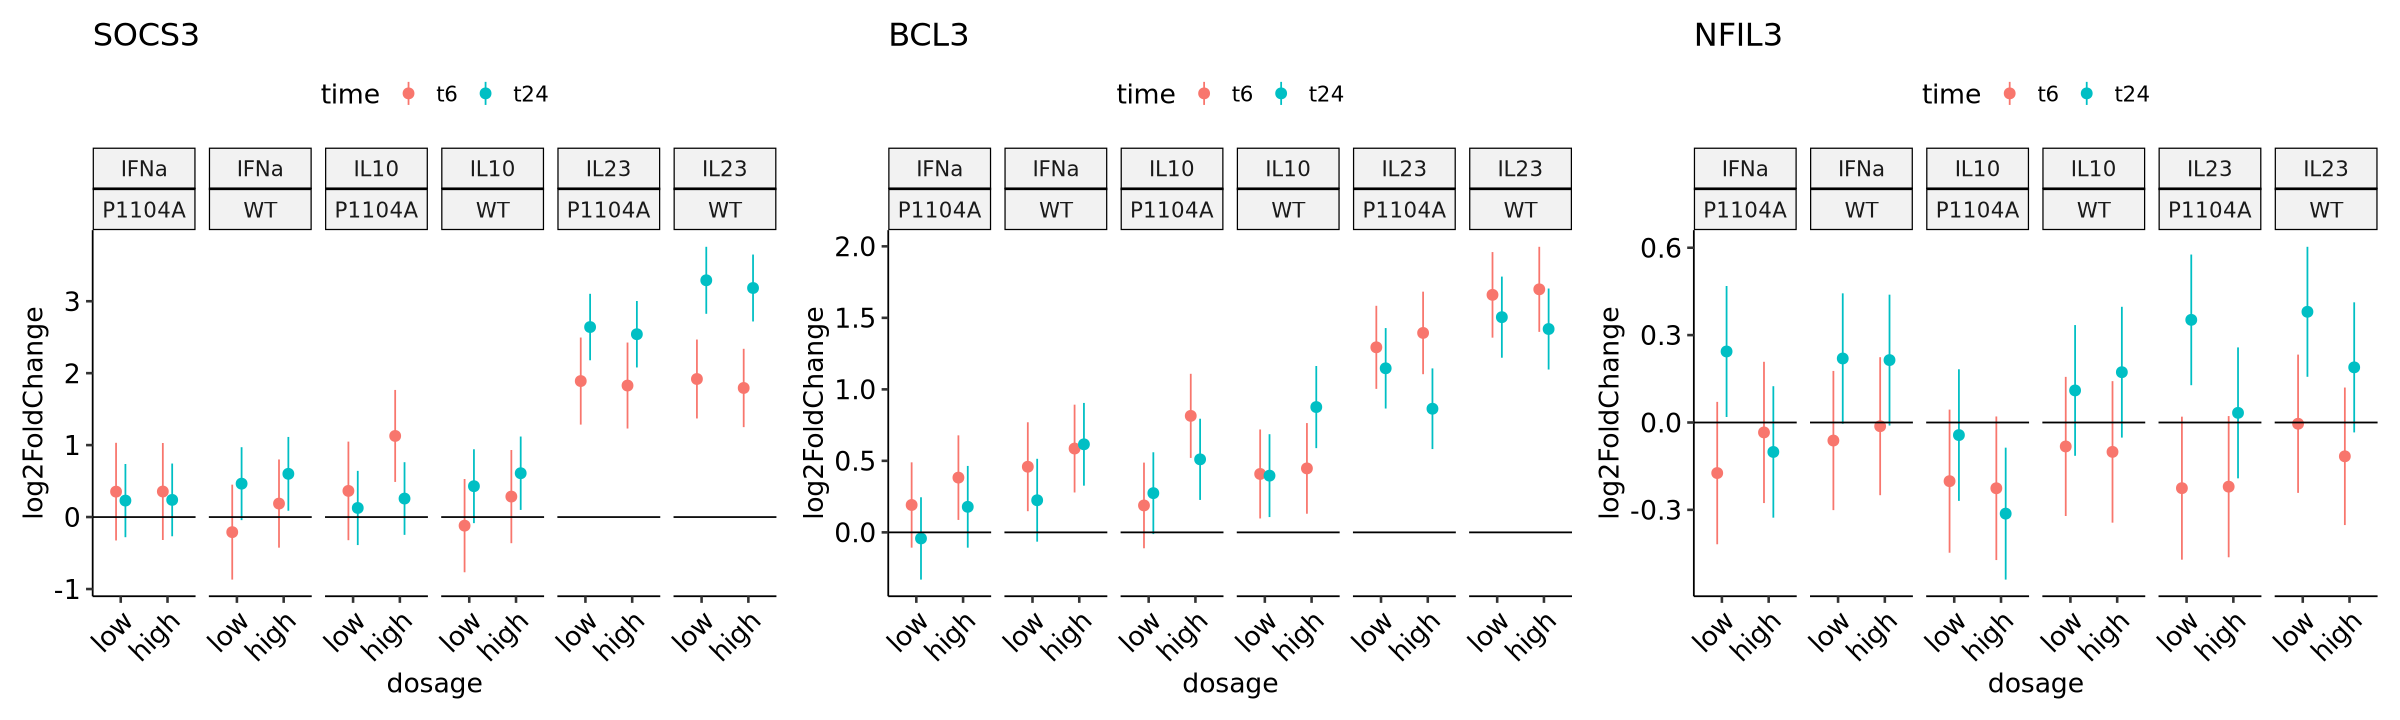

In [73]:
options(repr.plot.width = 20, repr.plot.height = 6)
plot_gene("SOCS3") + 
    plot_gene("BCL3") +
    plot_gene("NFIL3")